# Preparation Process for Study :

## Import To Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-azure-predictive-maintenance/PdM_errors.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_telemetry.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_failures.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_machines.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_maint.csv


In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use("Solarize_Light2")

%matplotlib inline

## Import To Dataset :

In [3]:
data_path = "/kaggle/input/microsoft-azure-predictive-maintenance/"

dataset_telemetry = pd.read_csv(f"{data_path}/PdM_telemetry.csv")

dataset_errors = pd.read_csv(f"{data_path}/PdM_errors.csv")

dataset_maintenance = pd.read_csv(f"{data_path}/PdM_maint.csv")

dataset_failures = pd.read_csv(f"{data_path}/PdM_failures.csv")

dataset_machines = pd.read_csv(f"{data_path}/PdM_machines.csv")

# Changing format's of date-time columns. Sort based on date for better readability
tables = [dataset_telemetry, dataset_maintenance, dataset_failures, dataset_errors]
for dataset in tables:
    dataset["datetime"] = pd.to_datetime(dataset["datetime"], format="%Y-%m-%d %H:%M:%S")
    dataset.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)


# Creating Functions of the Study:

In [4]:
def check_null(dataset):
    """
    Returns percentage of rows containing missing data
    """
    return dataset.isna().sum() * 100/len(dataset)


def get_missing_dates(series, start_date, end_date, freq="D"):
    """
    Returns the dates which are missing in the series
    date_sr between the start_date and end_date
    
    series: Series consisting of date
    start_date: Start date in String format
    end_date: End date in String format
    """
    return pd.date_range(
        start=start_date, end=end_date, freq=freq).difference(series)


def check_duplicate(dataset, subset):
    """
    Returns if there are any duplicate rows in the DataFrame.
    
    df: DataFrame under consideration
    subset: Optional List of feature names based on which 
            duplicate rows are being identified. 
    """
    if subset is not None: 
        return dataset.duplicated(subset=subset, keep=False).sum()
    else:
        return dataset.duplicated(keep=False).sum()


def create_date_features(source_df, target_df, feature_name):
    '''
    Create new features related to dates
    
    source_df : DataFrame consisting of the timestamp related feature
    target_df : DataFrame where new features will be added
    feature_name : Name of the feature of date type which needs to be decomposed.
    '''
    target_df.loc[:, 'year'] = source_df.loc[:, feature_name].dt.year.astype('uint16')
    target_df.loc[:, 'month'] = source_df.loc[:, feature_name].dt.month.astype('uint8')
    target_df.loc[:, 'quarter'] = source_df.loc[:, feature_name].dt.quarter.astype('uint8')
    target_df.loc[:, 'weekofyear'] = source_df.loc[:, feature_name].dt.isocalendar().week.astype('uint8')
    
    target_df.loc[:, 'hour'] = source_df.loc[:, feature_name].dt.hour.astype('uint8')
    
    target_df.loc[:, 'day'] = source_df.loc[:, feature_name].dt.day.astype('uint8')
    target_df.loc[:, 'dayofweek'] = source_df.loc[:, feature_name].dt.dayofweek.astype('uint8')
    target_df.loc[:, 'dayofyear'] = source_df.loc[:, feature_name].dt.dayofyear.astype('uint8')
    target_df.loc[:, 'is_month_start'] = source_df.loc[:, feature_name].dt.is_month_start
    target_df.loc[:, 'is_month_end'] = source_df.loc[:, feature_name].dt.is_month_end
    target_df.loc[:, 'is_quarter_start']= source_df.loc[:, feature_name].dt.is_quarter_start
    target_df.loc[:, 'is_quarter_end'] = source_df.loc[:, feature_name].dt.is_quarter_end
    target_df.loc[:, 'is_year_start'] = source_df.loc[:, feature_name].dt.is_year_start
    target_df.loc[:, 'is_year_end'] = source_df.loc[:, feature_name].dt.is_year_end
    
    # This is of type object
    target_df.loc[:, 'month_year'] = source_df.loc[:, feature_name].dt.to_period('M')
    
    return target_df


def plot_boxh_groupby(dataset, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    dataset.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(dataset, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        dataset[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        dataset[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(dataset, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        dataset[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        dataset[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_boxh(dataset, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        dataset[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        dataset[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(dataset, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot satter     
    """
    dataset.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    

def upper_col_name(dataset):
    upper_cols = [col.upper() for col in dataset.columns]
    dataset.columns = upper_cols
    return dataset.head()

In [5]:
upper_col_name(dataset_telemetry)

,DATETIME,MACHINEID,VOLT,ROTATE,PRESSURE,VIBRATION
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803


# Telemetry Dataset : 

In [6]:
print(f"Overview of the Telemetry Dataset: {dataset_telemetry.shape}")
print("\n")
dataset_telemetry.head()

Overview of the Telemetry Dataset: (876100, 6)




,DATETIME,MACHINEID,VOLT,ROTATE,PRESSURE,VIBRATION
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803


-- Descriptive statistics of the telemetry data. For Example:
    
    - Shape of data,
    - Unique values of the features
    - First&last 5 rows
    - Is there any null values for features?
    - What's the quantile values of numerical features

In [7]:
def check_df(dataset,head = 5):
    print("//////////DataFrame Shape\\\\\\\\\\")
    print(dataset.shape)
    print("//////////DataFrame Types\\\\\\\\\\")
    print(dataset.dtypes)
    print("//////////DataFrame Head(First 5 rows) \\\\\\\\\\")
    print(dataset.head(head))
    print("//////////DataFrame Tail(Last 5 rows) \\\\\\\\\\")
    print(dataset.tail(head))
    print("//////////DataFrame NaN Values \\\\\\\\\\")
    print(dataset.isnull().sum())
    print("//////////DataFrame Quantiles \\\\\\\\\\")
    print(dataset.quantile([0,0.25,0.50,0.75,1]).T)

In [8]:
check_df(dataset_telemetry)

//////////DataFrame Shape\\\\\
(876100, 6)
//////////DataFrame Types\\\\\
DATETIME     datetime64[ns]
MACHINEID             int64
VOLT                float64
ROTATE              float64
PRESSURE            float64
VIBRATION           float64
dtype: object
//////////DataFrame Head(First 5 rows) \\\\\
             DATETIME  MACHINEID        VOLT      ROTATE    PRESSURE  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 06:00:00          2  176.558913  424.624162   76.005332   
2 2015-01-01 06:00:00          3  185.482043  461.211137   87.453199   
3 2015-01-01 06:00:00          4  169.710847  463.646727   95.929877   
4 2015-01-01 06:00:00          5  165.082899  452.283576   84.591722   

   VIBRATION  
0  45.087686  
1  43.767049  
2  28.216864  
3  38.400372  
4  40.298803  
//////////DataFrame Tail(Last 5 rows) \\\\\
                  DATETIME  MACHINEID        VOLT      ROTATE    PRESSURE  \
876095 2016-01-01 06:00:00         96  157.157424  380.

## What is the time period in which the dataset was record?

In [9]:
dataset_telemetry.DATETIME.describe(datetime_is_numeric=True)

count                 876100
mean     2015-07-02 18:00:00
min      2015-01-01 06:00:00
25%      2015-04-02 12:00:00
50%      2015-07-02 18:00:00
75%      2015-10-02 00:00:00
max      2016-01-01 06:00:00
Name: DATETIME, dtype: object

- Telemetry values is distributed 1st Jan 2015 - 1st Jan 2016

- As we can see the datetime values having hourly frequency.

- Now, we can check to NaN values for dataset.

## Are there any NaN value in DATETIME feature ?

In [10]:
get_missing_dates(dataset_telemetry["DATETIME"], 
                  start_date= dataset_telemetry["DATETIME"].min(), 
                  end_date=dataset_telemetry["DATETIME"].max(), 
                  freq='H')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

- There is no NaN data .

- Multiplexed data may create noise in our study and cause our model to make inaccurate inferences. So we check if there are any duplicate rows of data.

## Are there any dublicated value ?

One Machine should not have multiple rows with the same time stamp.

In [11]:
check_duplicate(dataset_telemetry, ['DATETIME', 'MACHINEID'])

0

-- Well, as we can see, there is no dublicates in the dataset.

-- We have check to NaN value for DATETIME feature. But, we have to check null values for other features of dataset. 

## Are There Any NaN values in the Dataset ? 

In [12]:
check_null(dataset_telemetry)

DATETIME     0.0
MACHINEID    0.0
VOLT         0.0
ROTATE       0.0
PRESSURE     0.0
VIBRATION    0.0
dtype: float64

- There is no missing values in the data. That's good stution for our study.

- Okay, now, we can create some plots using by the features something like, Vibration, Voltage etc.

## Plots about Numerical Feature's of Machines

### 1. Vibraiton Values of Machine 1 for 2015 Period:

In [13]:
df_vib_machine_1 = dataset_telemetry.loc[(dataset_telemetry["MACHINEID"] == 1),("DATETIME", "VIBRATION")].set_index("DATETIME")

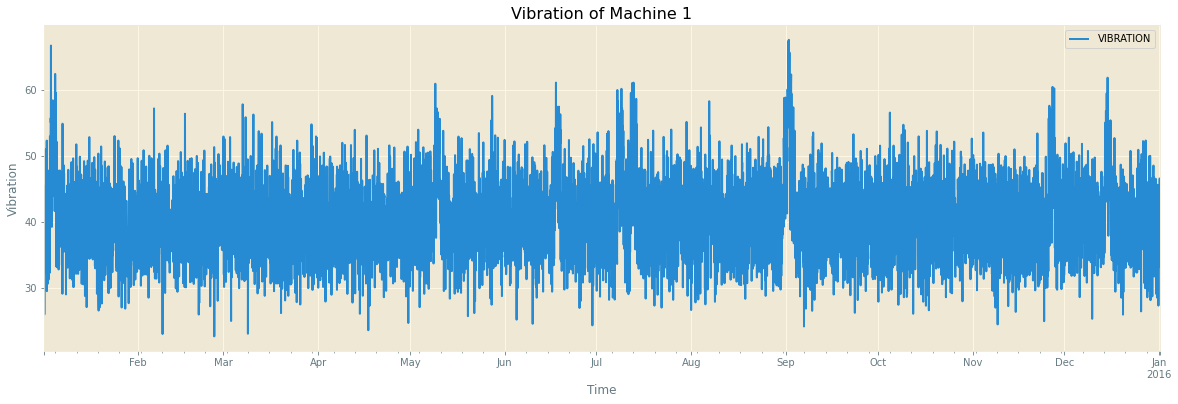

In [14]:
plot_ts(df_vib_machine_1, title="Vibration of Machine 1", xlabel="Time", ylabel="Vibration")

- It looks a little complicated. But when we examine it a little carefully, we can see that the vibration values are between 30-50, above the 60 vibration values of the outliers; It is also possible to see that it occurs below 30 vibration values.

### 2. Voltage Values of Machine 2 for 2015 Period:

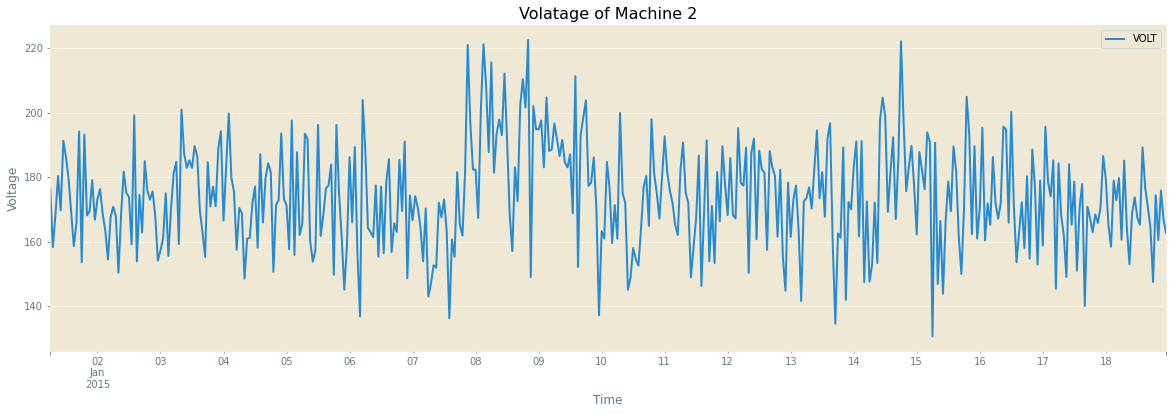

In [15]:
dataset_telemetry.loc[(dataset_telemetry["MACHINEID"] == 1),("DATETIME", "VIBRATION")].set_index("DATETIME")

# Let's plot voltage of Machine 2 for 1st two weeks of 2015
df_vib_machine_1 = dataset_telemetry.loc[(dataset_telemetry["MACHINEID"] == 2) & (dataset_telemetry["DATETIME"].dt.isocalendar().week.isin(
                                            [1, 2, 3]))][["DATETIME", "VOLT"]].set_index("DATETIME")
     
      
            
plot_ts(df_vib_machine_1, title="Volatage of Machine 2", xlabel="Time", ylabel="Voltage")

- We looked at the vibration value for Machine 1 and the Volt value for Machine 2 in time breakdown. Now we can create some new sub-variables by doing feature engineering from our DATETIME variable. For example, we generate variables that show which day of the week the relevant date is, and whether the relevant date is the end of the month or the beginning of the month. The reason why we produce these variables is the concern of obtaining a certain rule of the errors that occur in the machines. For example, while some production tools are working much more efficiently at the beginning of the week, this working performance can also trigger an error. Or other factors that occur over time in different scenarios may affect the breakdown of the relevant machine.

In [16]:
dataset_telemetry = create_date_features(dataset_telemetry, dataset_telemetry, "DATETIME")

In [17]:
upper_col_name(dataset_telemetry)

,DATETIME,MACHINEID,VOLT,ROTATE,PRESSURE,VIBRATION,YEAR,MONTH,QUARTER,WEEKOFYEAR,...,DAY,DAYOFWEEK,DAYOFYEAR,IS_MONTH_START,IS_MONTH_END,IS_QUARTER_START,IS_QUARTER_END,IS_YEAR_START,IS_YEAR_END,MONTH_YEAR
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01


### 3. VOLT values of the population over time :

- We plotted the volt value for Machine. For the ensemble in the dataset, we want to see the distribution of the voltage value over time so let's plot the Volts of the machines in the whole dataset.

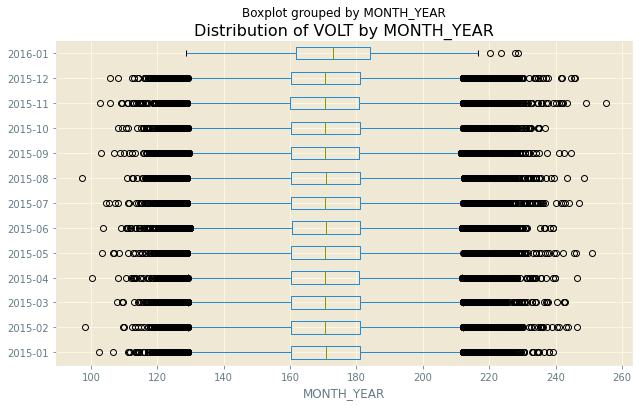

In [18]:
plot_boxh_groupby(dataset_telemetry, feature_name="VOLT", by="MONTH_YEAR")

- There is no noticeable change in Volt value over time. However, as a situation that can be said about the graph, since there was only 1 data point in 2016, this data point should be ignored and comment on the graph should be made. We see that the general population distribution, the average Volt value remains between 160-180.

- Let's choose a random machine in the data set and see how this machine's volt value changes over time.

### 4. Distribution of Volt values for Machine 80:

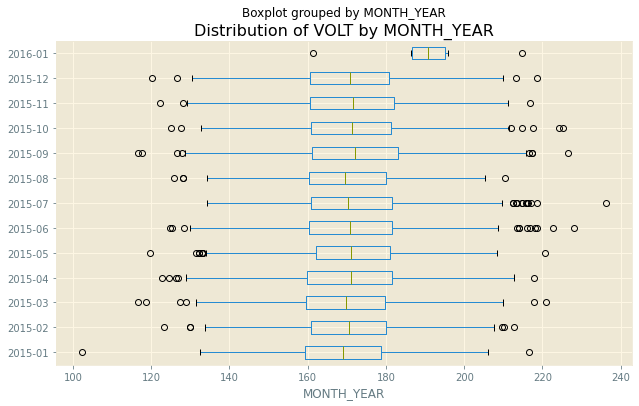

In [19]:
plot_boxh_groupby(dataset_telemetry.loc[(dataset_telemetry["MACHINEID"] == 80), :], feature_name="VOLT", by="MONTH_YEAR")

- With this visual, we proved the assumption that "Volt values are distributed similarly over time", which we made in the chart above. As we can see, there is no noticeable variability of volts in the machine 80 either.

### 5. Distribution of Voltage Values Across Machines:

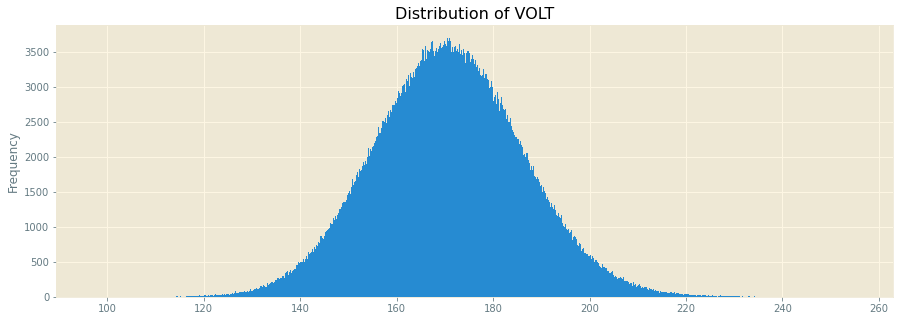

In [20]:
plot_hist(dataset_telemetry, feature_name="VOLT", log=False, bins=1000)

- Surprisingly, the volt values fit perfectly into the normal distribution. ***This indicates the possibility of synethetically generated data.***

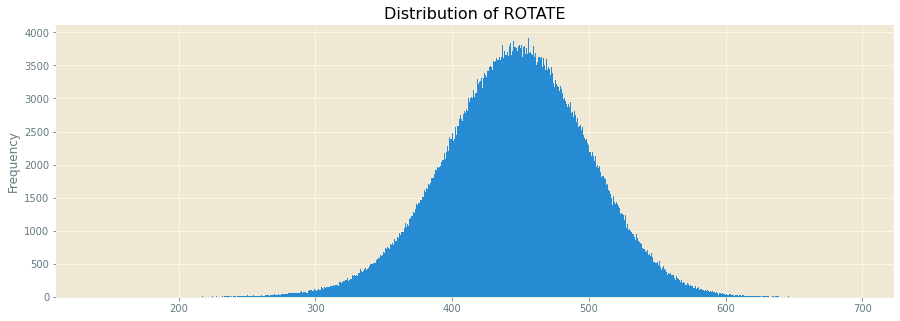

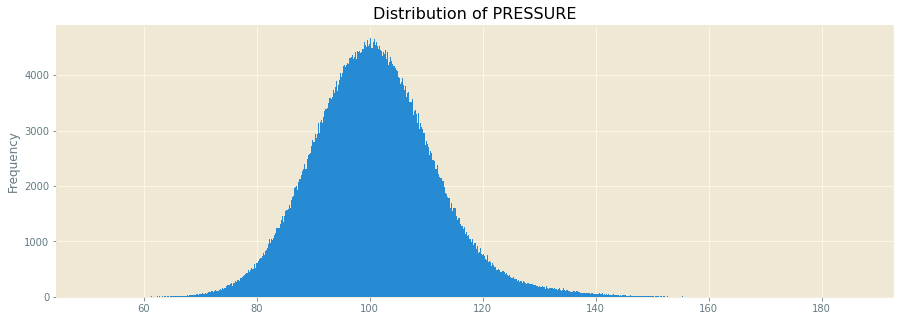

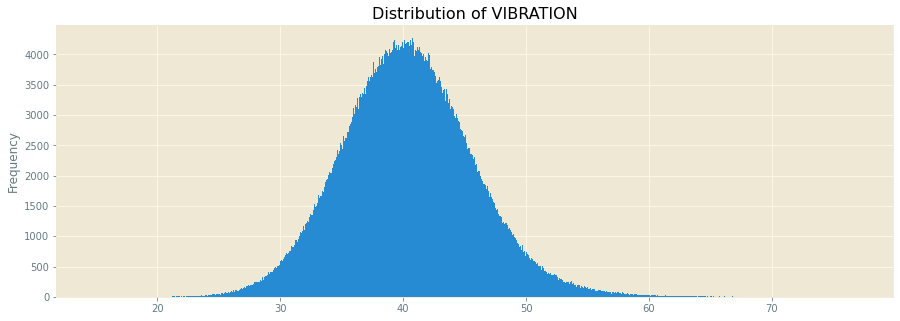

In [21]:
for feature in ['ROTATE', 'PRESSURE', 'VIBRATION']:
    plot_hist(dataset_telemetry, feature_name= feature, log=False, bins=1000)

**Conclusion information about telemetry values:**

- Our dataset includes machine data recorded between January 1, 2015 and January 1, 2016.

- The time period of our data set is seen hourly.

- There are 100 unique machines in our data set.

- In our data set, there is no missing value or duplicated data that could deviate the model in a possible ML algorithm solution and create bias. -Because it is synthetic data, we should not forget that we are working with healthy data. It will be difficult for us to encounter such clean data in real life data.

# Error Dataset : 

- In this part of the work, we will be focusing on data points labeled as signals that machines receive while they are operating. First of all, these data points do not count as machine failures, which is the focus of our study, as they do not interfere with the operation of the machines.

In [22]:
check_df(dataset_errors)

//////////DataFrame Shape\\\\\
(3919, 3)
//////////DataFrame Types\\\\\
datetime     datetime64[ns]
machineID             int64
errorID              object
dtype: object
//////////DataFrame Head(First 5 rows) \\\\\
             datetime  machineID errorID
0 2015-01-01 06:00:00         24  error1
1 2015-01-01 06:00:00         73  error4
2 2015-01-01 06:00:00         81  error1
3 2015-01-01 07:00:00         43  error3
4 2015-01-01 08:00:00         14  error4
//////////DataFrame Tail(Last 5 rows) \\\\\
                datetime  machineID errorID
3914 2015-12-31 18:00:00         91  error4
3915 2015-12-31 20:00:00         23  error3
3916 2015-12-31 23:00:00         94  error3
3917 2016-01-01 05:00:00          8  error3
3918 2016-01-01 05:00:00         30  error2
//////////DataFrame NaN Values \\\\\
datetime     0
machineID    0
errorID      0
dtype: int64
//////////DataFrame Quantiles \\\\\
           0.00  0.25  0.50  0.75   1.00
machineID   1.0  25.0  51.0  77.0  100.0


- Our error dataset consists of 3 variables and 3919 rows. Here are the errorID value containing each unique error class and the machineID columns representing each unique machine along with the time intervals when the errors occurred. Here we will first perform type renaming of ID columns as categorical values.

In [23]:
upper_col_name(dataset_errors)

,DATETIME,MACHINEID,ERRORID
0,2015-01-01 06:00:00,24,error1
1,2015-01-01 06:00:00,73,error4
2,2015-01-01 06:00:00,81,error1
3,2015-01-01 07:00:00,43,error3
4,2015-01-01 08:00:00,14,error4


In [24]:
dataset_errors["MACHINEID"] = dataset_errors["MACHINEID"].astype('category')
dataset_errors["ERRORID"] = dataset_errors["ERRORID"].astype('category')

## What is the time period in which the dataset was record?

In [25]:
dataset_errors["DATETIME"].describe(datetime_is_numeric=True)

count                             3919
mean     2015-07-01 03:34:18.586373888
min                2015-01-01 06:00:00
25%                2015-03-31 05:00:00
50%                2015-07-01 06:00:00
75%                2015-10-01 15:00:00
max                2016-01-01 05:00:00
Name: DATETIME, dtype: object

- The Errors dataset contains the same time intervals as telemetry. Beginning January 1, 2015 and ending January 1, 2016

- In addition, the dataset maintains an hourly timeframe.

## Are there any dublicated value ?

In [26]:
check_duplicate(dataset_errors, ['DATETIME', 'MACHINEID', 'ERRORID'])

0

## Are there any NaN values ?

In [27]:
check_null(dataset_errors)

DATETIME     0.0
MACHINEID    0.0
ERRORID      0.0
dtype: float64

## Plots about Error Types :

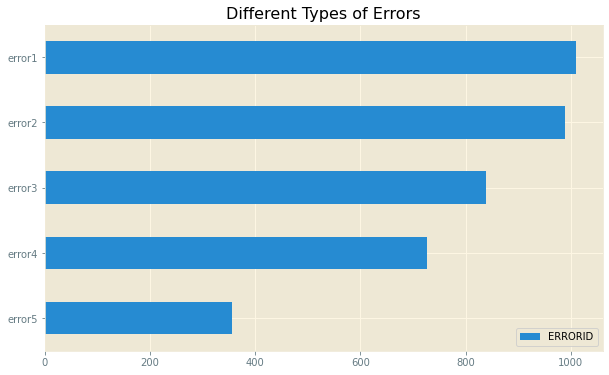

In [28]:
plot_barh(dataset_errors, 
          feature_name="ERRORID", 
          figsize=(10, 6), 
          normalize=False,
          title="Different Types of Errors")

- As can be seen, Type 1 and Type 2 error types were more common.

- Now, which error code has been seen on which machine and how many times? We create a barplot to access this information.

## How many error signals did each machine generate?

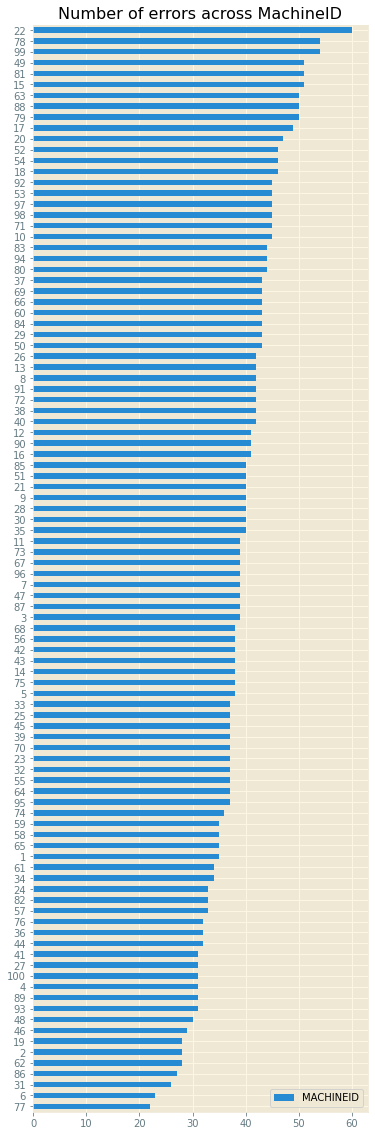

In [29]:
plot_barh(dataset_errors, "MACHINEID", figsize=(6, 20), normalize=False, title="Number of errors across MachineID")

- As expected, machines with different specifications signal different levels of error.

- Now, let's examine which error code is at what intensity according to the machine type, by adding the color dimension.

## How does the Machine to type of error distribution looks like?

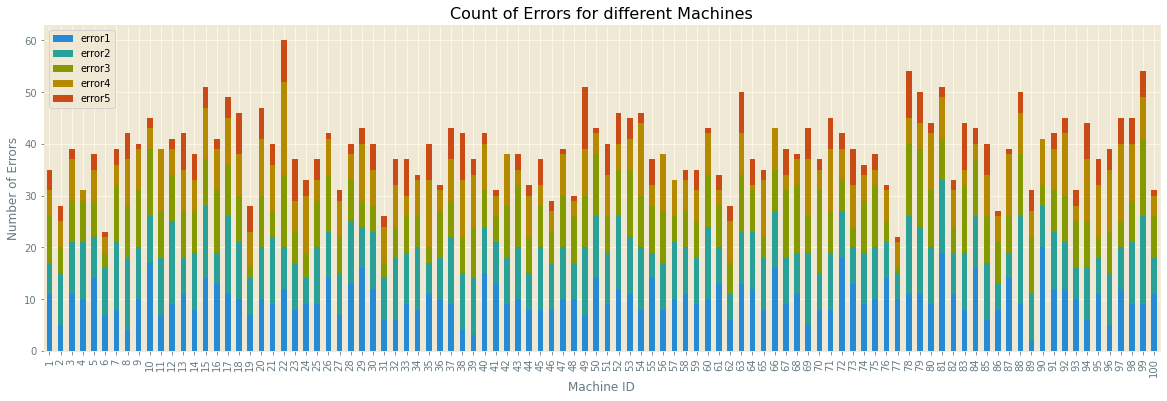

In [30]:
dataset_errors_ = dataset_errors.groupby(["MACHINEID", "ERRORID"]).size().reset_index()
dataset_errors_.columns = ["MACHINEID", "ERRORID", "errorValues"]
#df_errors_pivot = pd.pivot(df_errors, index="machineID", columns="errorID", values="errorValues").reset_index().rename_axis(None, axis=1)
dataset_errors_pivot = pd.pivot(dataset_errors_, index="MACHINEID", columns="ERRORID", values="errorValues").rename_axis(None, axis=1)

dataset_errors_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Errors for different Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of Errors");

## Error signal occurrence amounts by day :

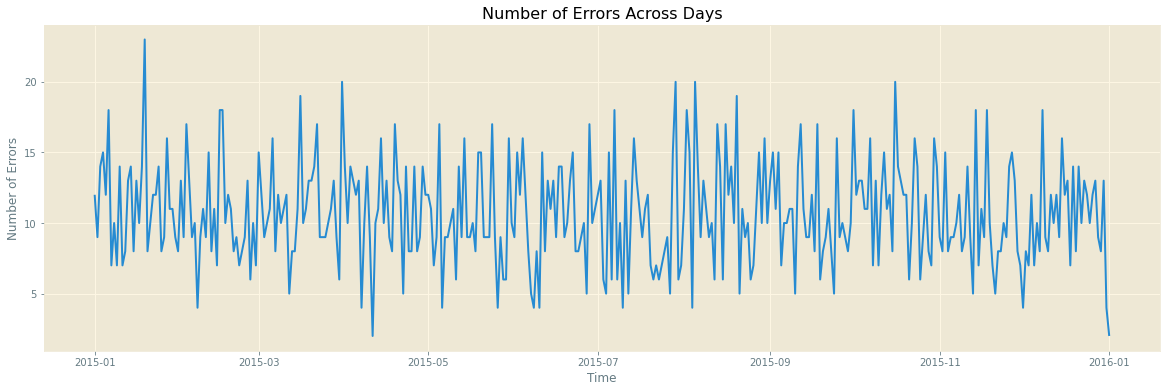

In [31]:
plot_ts(
    dataset_errors["DATETIME"].dt.date.value_counts().sort_index(), 
    figsize=(20, 6), 
    title="Number of Errors Across Days", 
    xlabel="Time",
    ylabel="Number of Errors")

- Let's see how some specific machines produce errors in a certain period with a scatter plot:

## How does the error distribution looks for a particluar machine?

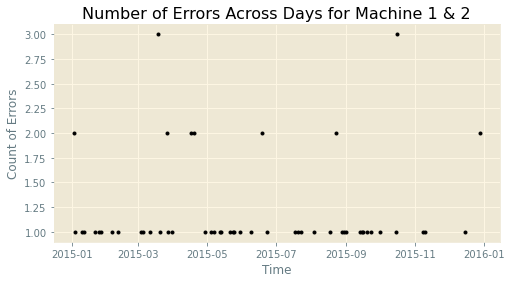

In [32]:
df_temp = dataset_errors[dataset_errors["MACHINEID"].isin([1, 2])]["DATETIME"].dt.date.value_counts().sort_index()
df_temp.plot(style="k.", figsize=(8, 4), title="Number of Errors Across Days for Machine 1 & 2")
plt.ylabel("Count of Errors")
plt.xlabel("Time")
plt.show()

- When we look at the graph, the daily error signal generation frequency for machine 1 and machine 2 we have chosen is 1. However, as an outlier, there are times when it gives more than 1 error signal.

- Now, let's show the distribution of the error amount according to the days in the density graph.

## Distribution of daily error amount:

In [33]:
dataset_errors

,DATETIME,MACHINEID,ERRORID
0,2015-01-01 06:00:00,24,error1
1,2015-01-01 06:00:00,73,error4
2,2015-01-01 06:00:00,81,error1
3,2015-01-01 07:00:00,43,error3
4,2015-01-01 08:00:00,14,error4
...,...,...,...
3914,2015-12-31 18:00:00,91,error4
3915,2015-12-31 20:00:00,23,error3
3916,2015-12-31 23:00:00,94,error3
3917,2016-01-01 05:00:00,8,error3


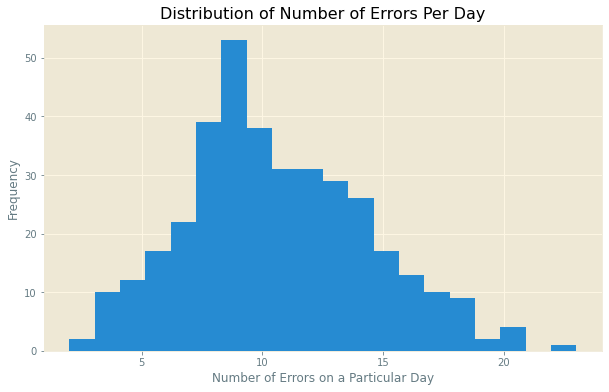

In [34]:
dataset_errors['DATE'] = dataset_errors["DATETIME"].dt.date

dataset_errors.groupby('DATE').size().hist(bins=20, figsize=(10, 6))
plt.title("Distribution of Number of Errors Per Day")
plt.xlabel("Number of Errors on a Particular Day")
plt.ylabel("Frequency")
plt.show()

Error data summary:

- Our data includes the display of error signals by machines from January 1 to January 1, 2016.

- There were 3919 errors.

- As can be seen from the density graph, the daily error value of all owned machines is distributed with an average of ~10-15.

- Machines with different features have a different tendency to generate error signals.

# Maintenance Data:

When we examine the maintenance data, we need to give the following information as a preliminary definition:

* If a component of a machine is replaced, it is kept as a record in this table. Components are replaced in two cases:

    - Technician replaced it during regularly scheduled visit (Proactive Maintenance)

    - A component fails, and then the technician performs unscheduled maintenance to replace the component (Reactive Maintenance). This is considered a fault and the relevant data is collected under Faults. Maintenance data has both 2014 and 2015 records. Since telemetry data is collected hourly, this data is rounded to the nearest hour.

In [35]:
upper_col_name(dataset_maintenance)

,DATETIME,MACHINEID,COMP
0,2014-06-01 06:00:00,1,comp2
1,2014-06-01 06:00:00,6,comp2
2,2014-06-01 06:00:00,9,comp1
3,2014-06-01 06:00:00,9,comp2
4,2014-06-01 06:00:00,11,comp2


In [36]:
print(f"Shape of the Maintenance Records: {dataset_maintenance.shape}")
print("\n")
dataset_maintenance.head()

Shape of the Maintenance Records: (3286, 3)




,DATETIME,MACHINEID,COMP
0,2014-06-01 06:00:00,1,comp2
1,2014-06-01 06:00:00,6,comp2
2,2014-06-01 06:00:00,9,comp1
3,2014-06-01 06:00:00,9,comp2
4,2014-06-01 06:00:00,11,comp2


In [37]:
for feature in ["MACHINEID", "COMP"]:
    dataset_maintenance[feature] = dataset_maintenance[feature].astype("category")
    
dataset_maintenance.sort_values(["DATETIME", "MACHINEID", "COMP"], inplace=True)

# Add date related features.
dataset_maintenance = create_date_features(dataset_maintenance, dataset_maintenance, "DATETIME")

## What is the duration of the data?

In [38]:
dataset_maintenance["DATETIME"].describe(datetime_is_numeric=True).T

count                             3286
mean     2015-05-30 14:40:36.518563840
min                2014-06-01 06:00:00
25%                2015-03-03 06:00:00
50%                2015-06-13 06:00:00
75%                2015-09-18 00:00:00
max                2016-01-01 06:00:00
Name: DATETIME, dtype: object

- Maintenance data is present June 2014 onwards. This is different from other data which are present between 2014 and 2015.

In [39]:
get_missing_dates(dataset_maintenance["DATETIME"], 
                  start_date=dataset_maintenance["DATETIME"].min(), 
                  end_date=dataset_maintenance["DATETIME"].max(), 
                  freq='H')

DatetimeIndex(['2014-06-01 07:00:00', '2014-06-01 08:00:00',
               '2014-06-01 09:00:00', '2014-06-01 10:00:00',
               '2014-06-01 11:00:00', '2014-06-01 12:00:00',
               '2014-06-01 13:00:00', '2014-06-01 14:00:00',
               '2014-06-01 15:00:00', '2014-06-01 16:00:00',
               ...
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00',
               '2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00'],
              dtype='datetime64[ns]', length=13523, freq=None)

In [40]:
upper_col_name(dataset_maintenance)

,DATETIME,MACHINEID,COMP,YEAR,MONTH,QUARTER,WEEKOFYEAR,HOUR,DAY,DAYOFWEEK,DAYOFYEAR,IS_MONTH_START,IS_MONTH_END,IS_QUARTER_START,IS_QUARTER_END,IS_YEAR_START,IS_YEAR_END,MONTH_YEAR
0,2014-06-01 06:00:00,1,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
1,2014-06-01 06:00:00,6,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
2,2014-06-01 06:00:00,9,comp1,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
3,2014-06-01 06:00:00,9,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
4,2014-06-01 06:00:00,11,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06


## Let's plot number of maintenance records across months: 

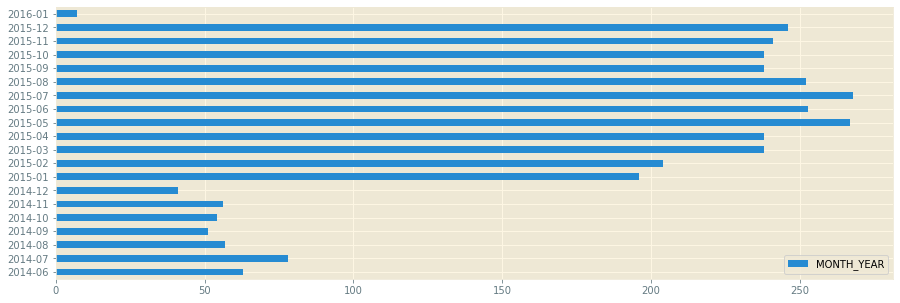

In [41]:
plot_barh(dataset_maintenance, "MONTH_YEAR", normalize=False, sort_index=True)

- Number of components replaced in the year 2015 are considerably higher compared to the 2014.

- Again, we can ignore the data for 2016 (since we have only one day's data)

## Let's check the number of components replaced:

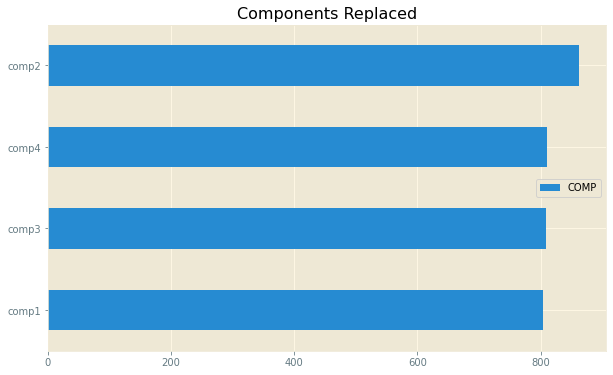

In [42]:
plot_barh(dataset_maintenance, 
          feature_name="COMP", 
          figsize=(10, 6), 
          normalize=False,
          title="Components Replaced")

- Four types components are replaced almost in the same numbers.

## Let's plot the number of Maintenance Records Across Machines:

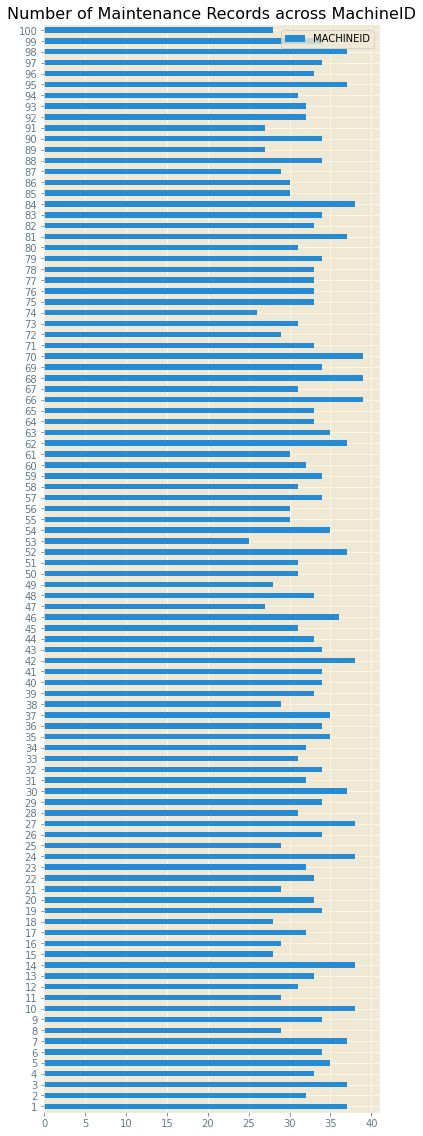

In [43]:
plot_barh(dataset_maintenance, "MACHINEID", 
          figsize=(6, 20), 
          normalize=False, 
          title="Number of Maintenance Records across MachineID", 
          sort_index=True)

## How does the Machine to different component replaced looks like?:

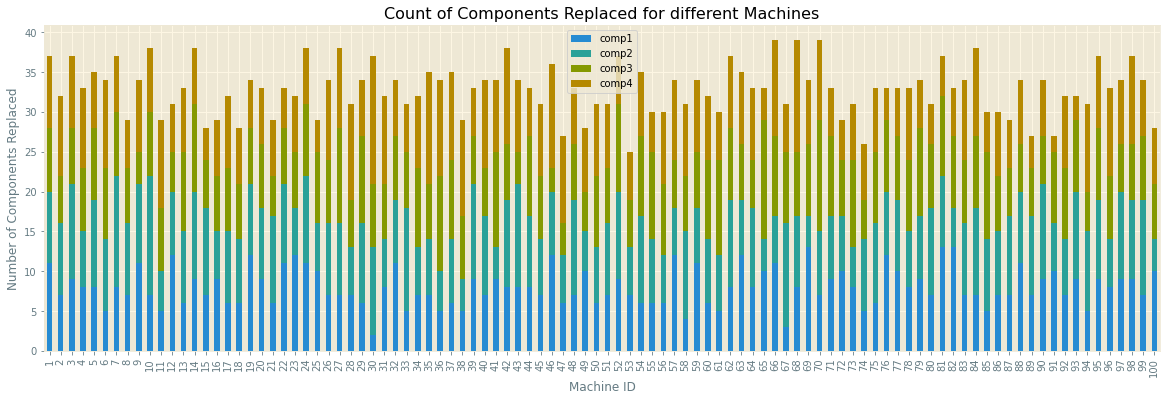

In [44]:
df_maint = dataset_maintenance.groupby(["MACHINEID", "COMP"]).size().reset_index()
df_maint.columns = ["MACHINEID", "COMP", "NUM_COMP"]
df_maint_pivot = pd.pivot(df_maint, index="MACHINEID", columns="COMP", values="NUM_COMP").rename_axis(None, axis=1)

df_maint_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Components Replaced for different Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of Components Replaced");

## Plot number of Maintenance Issues reaised per day : 

In [45]:
dataset_maintenance

,DATETIME,MACHINEID,COMP,YEAR,MONTH,QUARTER,WEEKOFYEAR,HOUR,DAY,DAYOFWEEK,DAYOFYEAR,IS_MONTH_START,IS_MONTH_END,IS_QUARTER_START,IS_QUARTER_END,IS_YEAR_START,IS_YEAR_END,MONTH_YEAR
0,2014-06-01 06:00:00,1,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
1,2014-06-01 06:00:00,6,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
2,2014-06-01 06:00:00,9,comp1,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
3,2014-06-01 06:00:00,9,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
4,2014-06-01 06:00:00,11,comp2,2014,6,2,22,6,1,6,152,True,False,False,False,False,False,2014-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,2016-01-01 06:00:00,35,comp2,2016,1,1,53,6,1,4,1,True,False,True,False,True,False,2016-01
3282,2016-01-01 06:00:00,42,comp4,2016,1,1,53,6,1,4,1,True,False,True,False,True,False,2016-01
3283,2016-01-01 06:00:00,43,comp1,2016,1,1,53,6,1,4,1,True,False,True,False,True,False,2016-01
3284,2016-01-01 06:00:00,55,comp3,2016,1,1,53,6,1,4,1,True,False,True,False,True,False,2016-01


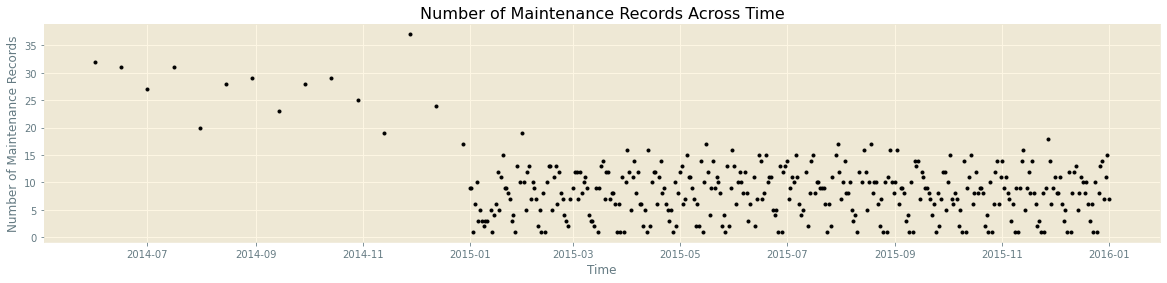

In [46]:
dataset_maintenance["DATETIME"].dt.date.value_counts().plot(
    style="k.", 
    figsize=(20, 4), 
    title="Number of Maintenance Records Across Time")
plt.ylabel("Number of Maintenance Records")
plt.xlabel("Time")
plt.show()

- This indicates that there is a drastic difference between the number of maintenance records in 2014 vs 2015.

# Failure Data: 

## Static Data of Machines: 

- This data set includes some information about the machines: model type and age (years in service)

In [47]:
print(f"Shape of the Machines Data: {dataset_machines.shape}")
print("\n")
dataset_machines.head()

Shape of the Machines Data: (100, 3)




,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [48]:
upper_col_name(dataset_machines)

,MACHINEID,MODEL,AGE
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


## Plot the distribution of age of the Machines:

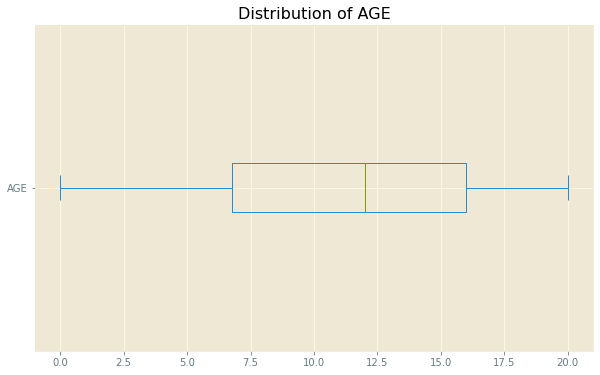

In [49]:
plot_boxh(dataset_machines, feature_name="AGE", log=False)

- The age of the Machines is distributed between 0 to 20. The median age is to ~12.5. There are no outliers. Another indication that this is a synthetic data.

## Plot Age vs Number of Failures: 

In [50]:
dataset_errors

,DATETIME,MACHINEID,ERRORID,DATE
0,2015-01-01 06:00:00,24,error1,2015-01-01
1,2015-01-01 06:00:00,73,error4,2015-01-01
2,2015-01-01 06:00:00,81,error1,2015-01-01
3,2015-01-01 07:00:00,43,error3,2015-01-01
4,2015-01-01 08:00:00,14,error4,2015-01-01
...,...,...,...,...
3914,2015-12-31 18:00:00,91,error4,2015-12-31
3915,2015-12-31 20:00:00,23,error3,2015-12-31
3916,2015-12-31 23:00:00,94,error3,2015-12-31
3917,2016-01-01 05:00:00,8,error3,2016-01-01


In [51]:
upper_col_name(dataset_failures)

,DATETIME,MACHINEID,FAILURE
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1


In [52]:
# Create a DF with number of errors, maintenance records and failure records across machines

# Create a DF consisting of number of erros across Machines
erros_across_machine = dataset_errors.groupby("MACHINEID").size()
erros_across_machine = pd.DataFrame(erros_across_machine, columns=["NUM_ERRORS"]).reset_index()

machines_errors_df = pd.merge(dataset_machines, erros_across_machine, how='left', on="MACHINEID")

# Create a DF consisting of number of maintenance records across Machines
maint_across_machine = dataset_maintenance.groupby("MACHINEID").size()
maint_across_machine = pd.DataFrame(maint_across_machine, columns=["NUM_MAINT"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, maint_across_machine, how='left', on="MACHINEID")

# Create a DF consisting of number of failure records across Machines
failure_across_machine = dataset_failures.groupby("MACHINEID").size()
failure_across_machine = pd.DataFrame(failure_across_machine, columns=["NUM_FAILURE"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, failure_across_machine, how='left', on="MACHINEID")

machines_errors_df.head()

,MACHINEID,MODEL,AGE,NUM_ERRORS,NUM_MAINT,NUM_FAILURE
0,1,model3,18,35,37,7.0
1,2,model4,7,28,32,4.0
2,3,model3,8,39,37,5.0
3,4,model3,7,31,33,6.0
4,5,model3,2,38,35,7.0


## Plot Number of Errors across Machine Age:

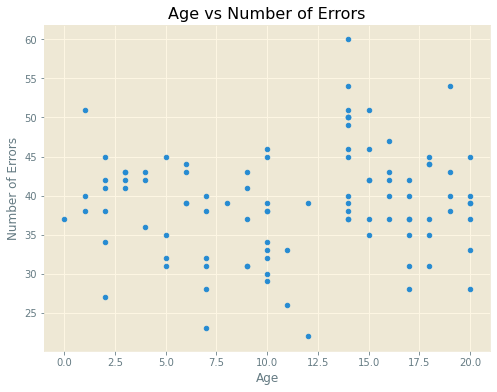

In [53]:
plot_scatter(machines_errors_df, "AGE", "NUM_ERRORS", 
             title="Age vs Number of Errors", 
             xlabel="Age", ylabel="Number of Errors")

## Plot Age vs Number of Maintenance Records

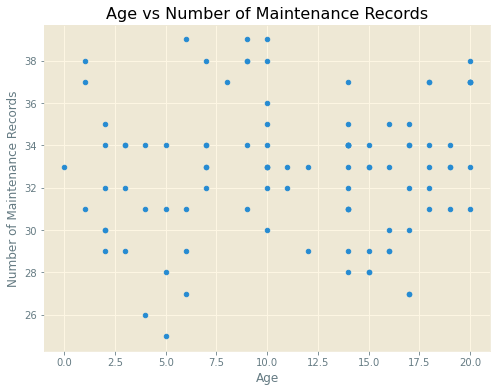

In [54]:
plot_scatter(machines_errors_df, "AGE", "NUM_MAINT", 
             title="Age vs Number of Maintenance Records", 
             xlabel="Age", ylabel="Number of Maintenance Records")

## Plot Age vs Number of Failure Records:

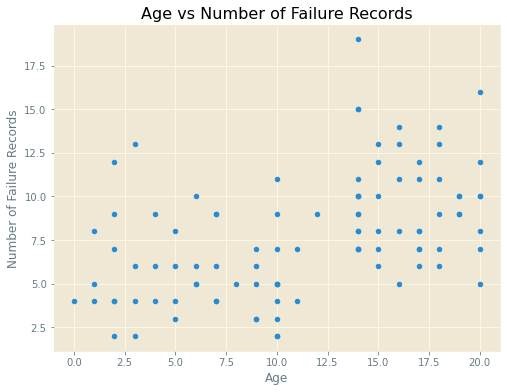

In [55]:
plot_scatter(machines_errors_df, "AGE", "NUM_FAILURE", 
             title="Age vs Number of Failure Records", 
             xlabel="Age", ylabel="Number of Failure Records")

- From the above three plots, it appears only Number of Failures is slightly correlated with Age.

- Let's verify it with a correlation values.

In [56]:
machines_errors_df.corr()

,AGE,NUM_ERRORS,NUM_MAINT,NUM_FAILURE
AGE,1.000000,0.106931,0.075445,0.476459
NUM_ERRORS,0.106931,1.000000,-0.026558,0.483735
NUM_MAINT,0.075445,-0.026558,1.000000,-0.030258
NUM_FAILURE,0.476459,0.483735,-0.030258,1.000000


# SUMMARY :

- While performing the predictive maintenance analysis, the variables and factors that are considered in general terms are the static values of the relevant machine and the IoT sensor data that are included in our lives with Industry 4.0.

- When we say static data of a workbench, the variables that should come to mind are the age of the machine, the functionality of the machine, the dimensions of the machine depending on the situation, and the equipment features of the machine.

- Sensor data, in general terms, are temperature, vibration, volt and pressure values according to machine type taken from the machine with sensors.

- Predictive maintenance analysis is a work that can be done easily in a production facility so that the machine can provide quality service and work is not disrupted.

- Static data of the production device are important considerations when performing predictive maintenance analysis work in a manufacturing facility. If these data are known, malfunctions in the production device can be easily explained or rule-based inferences can be made.